In [1]:
import subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
from obspy import read_inventory
import pygmt
import shutil
import json
from tqdm import tqdm
import re
from pyFMST import fmst, fmstUtils

In [2]:
grids = {}
gridc = {}
backv = {}
covar = {}

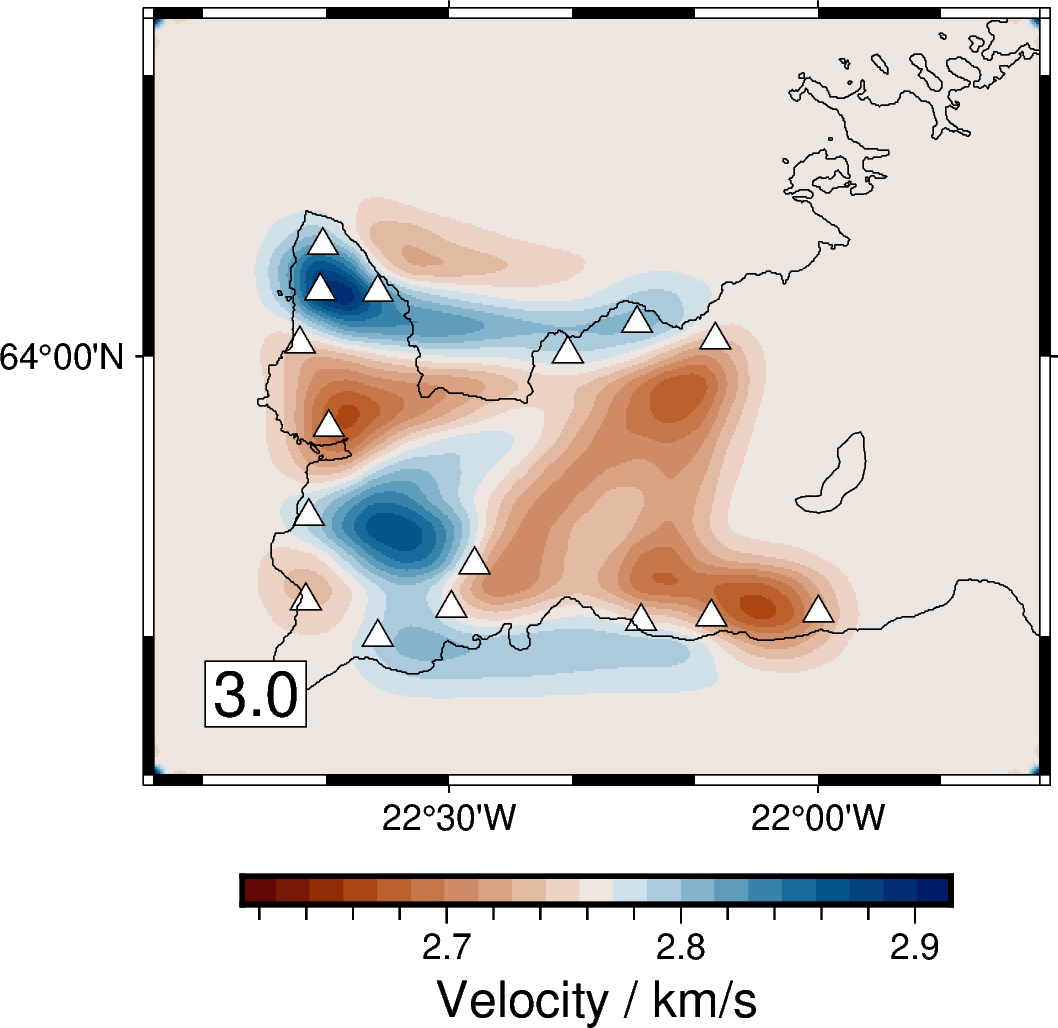

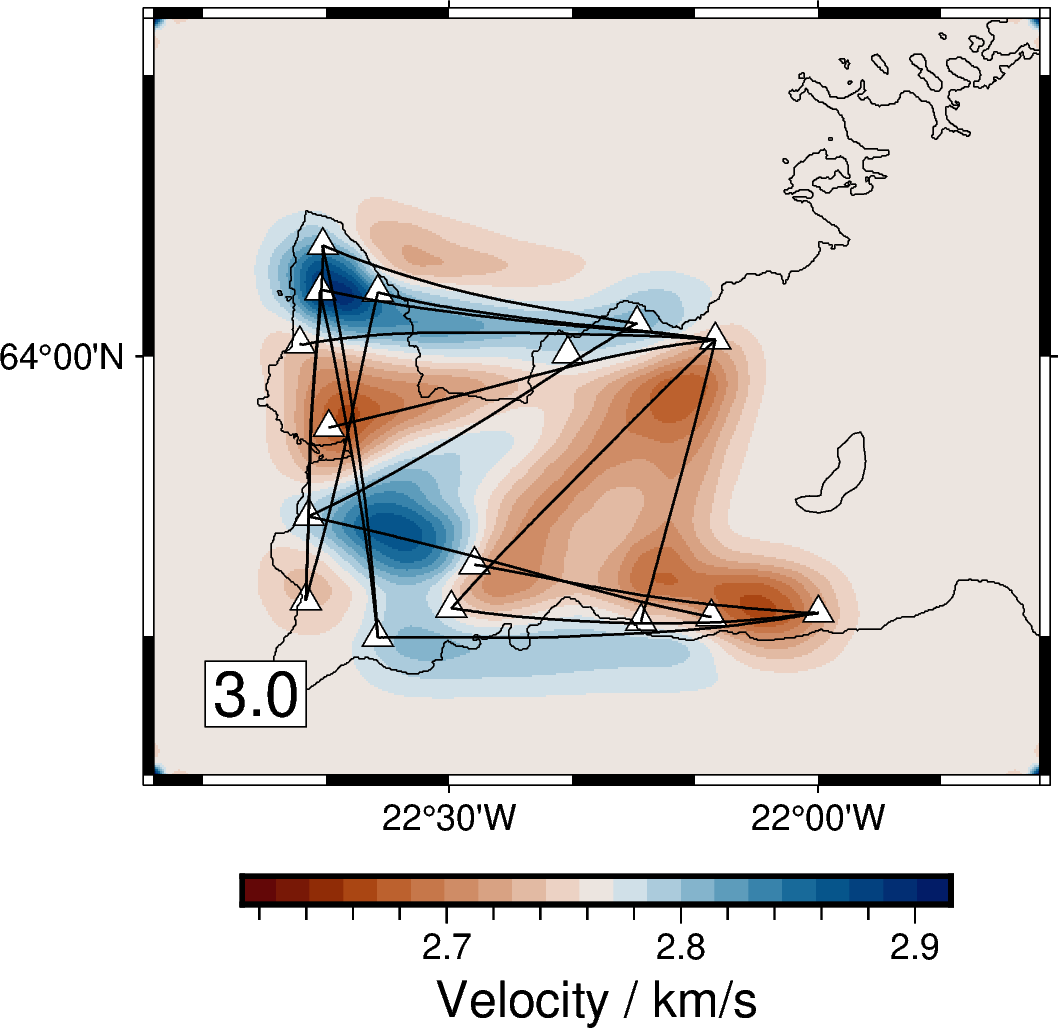

        0        1
0  183.67  0.03584
1   99.92  0.01061
2   99.89  0.01060
3   97.14  0.01003
4   97.33  0.01007
5   96.94  0.00998
6   96.94  0.00999


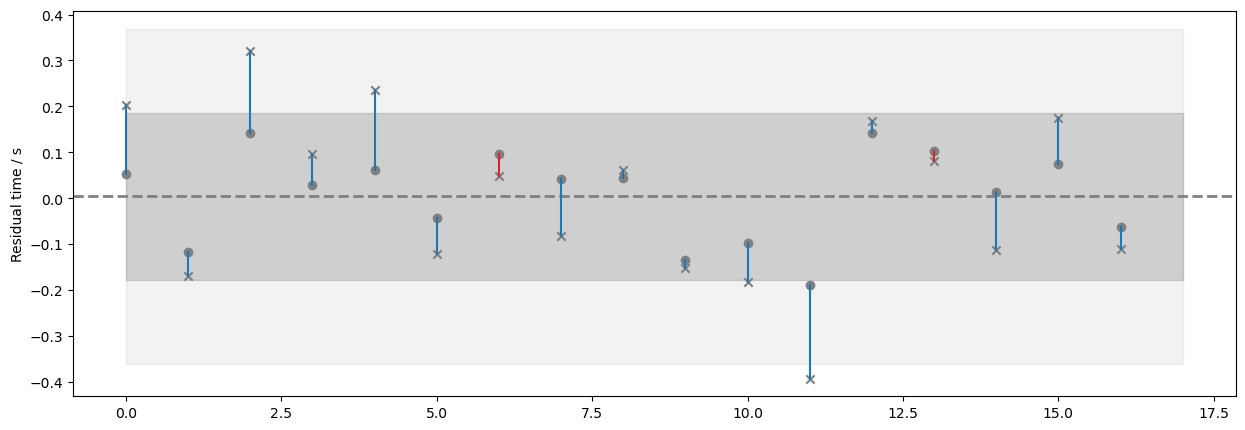

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:22<00:00,  3.83s/it]


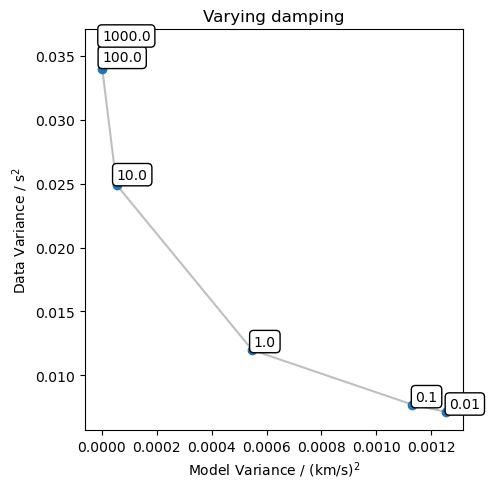

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:23<00:00,  3.84s/it]


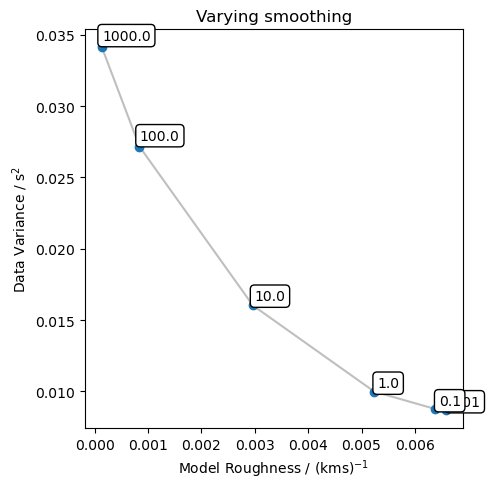

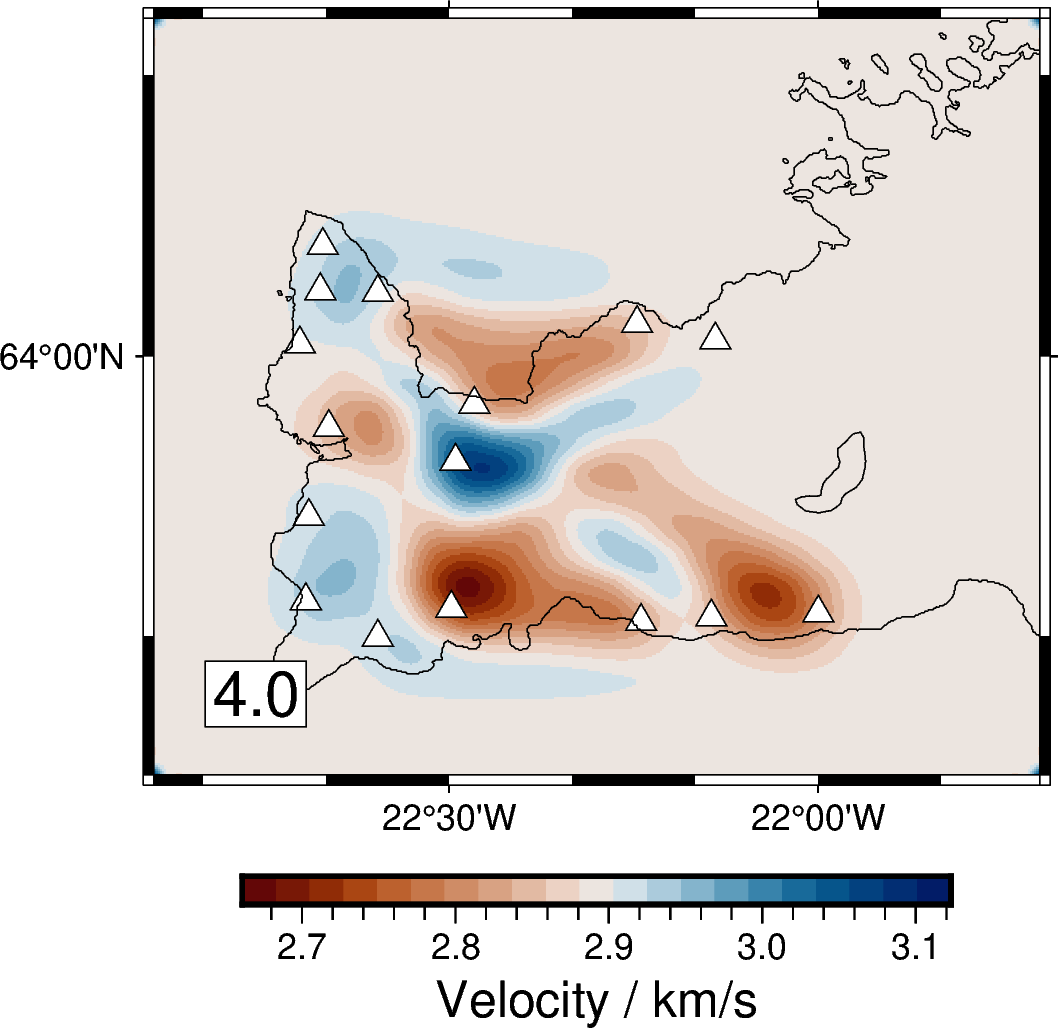

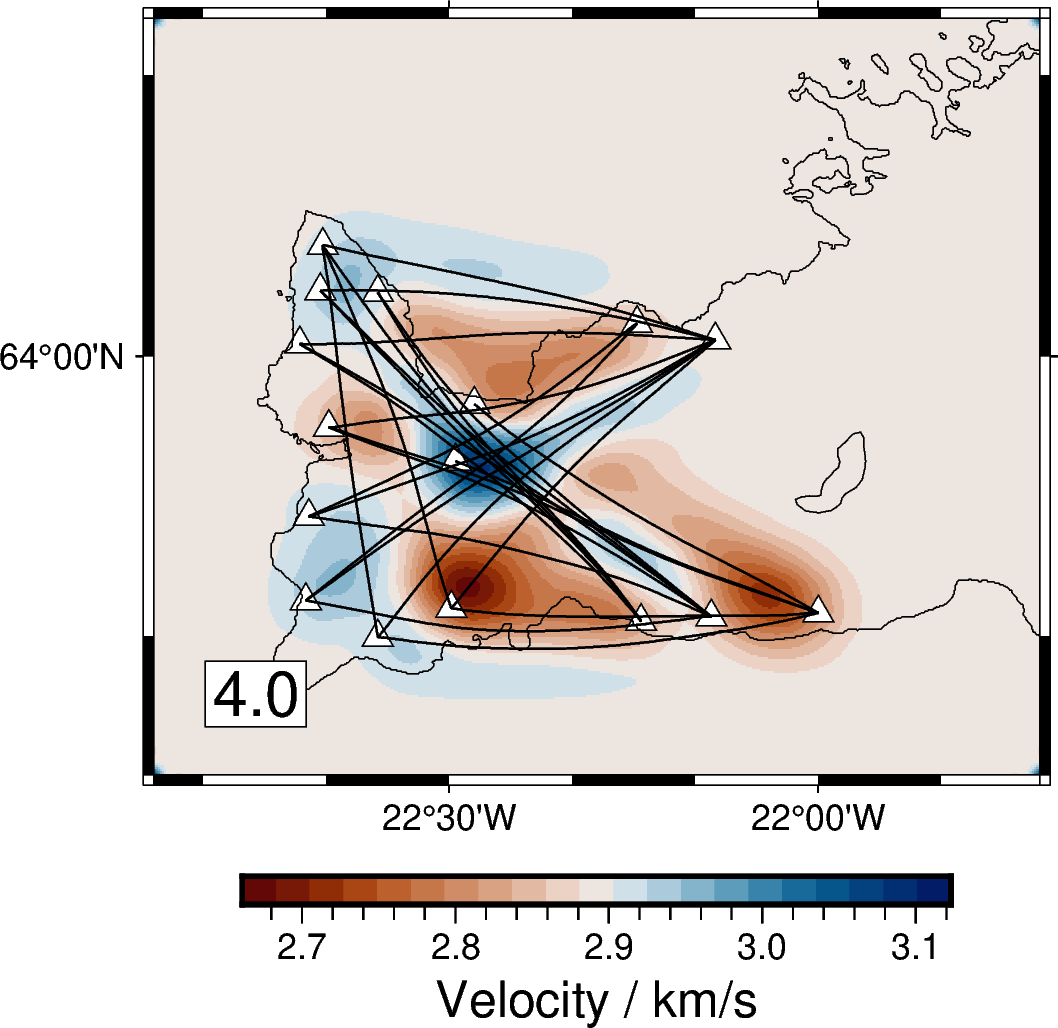

        0        1
0  224.38  0.05228
1  132.87  0.01833
2  130.01  0.01755
3  123.26  0.01578
4  123.96  0.01596
5  122.69  0.01563
6  122.87  0.01568


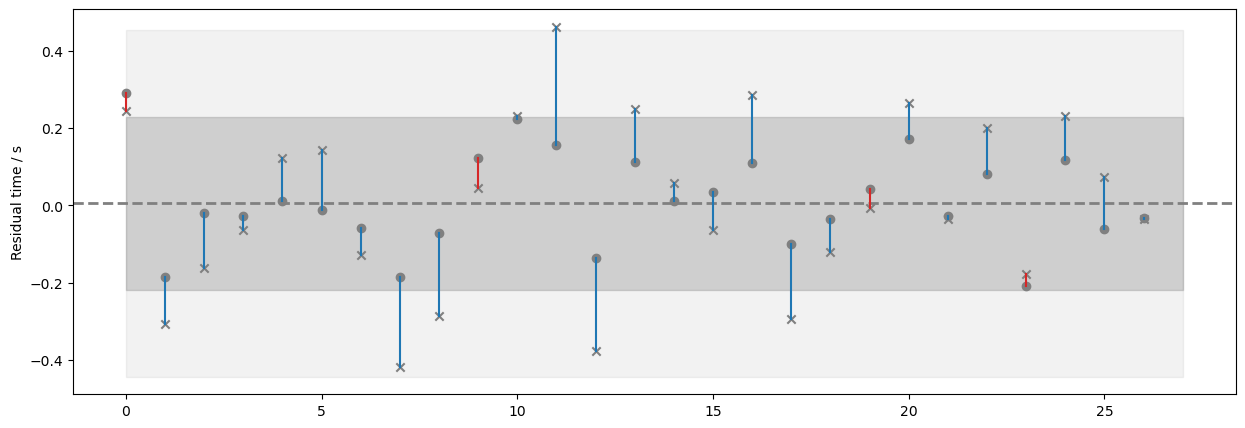

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:22<00:00,  3.82s/it]


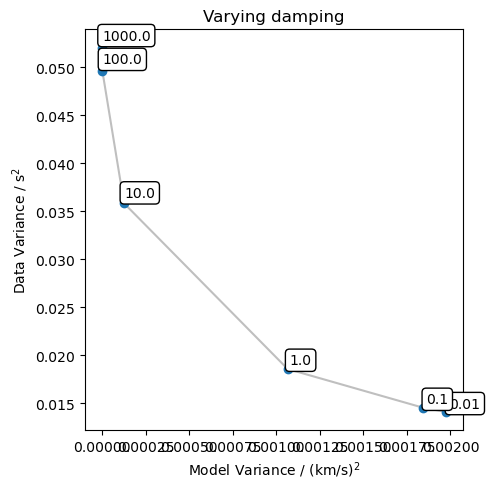

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:22<00:00,  3.81s/it]


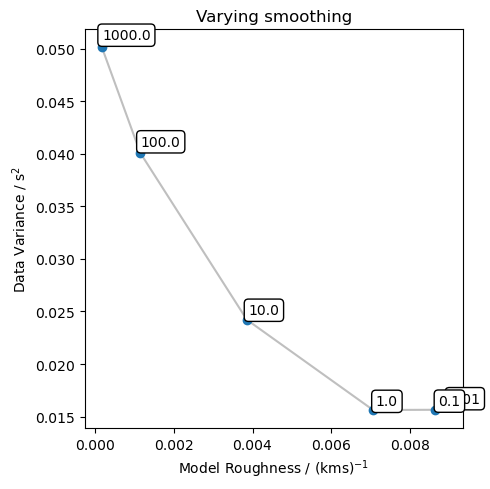

In [7]:
lat_num = 27
lon_num = 31

freqs=[3.0,4.0]

for freq in freqs:
    tomo = fmst(path="./FMST", templates="../../templates")
    
    tomo.load_velocity_pairs("picks.json", freq)
    tomo.set_region(region=[64.2, 63.75, -22.9, -21.7])
    
    tomo.load_stations('response.xml')
    tomo.read_station_pairs("station_pairs.csv", drop=True)
    
    tomo.refine_station_pairs(method='std', arg=2.0)
    
    tomo.set_background_vel(np.average(tomo.station_pairs_complete['vel'], weights=tomo.station_pairs_complete['gcm']))
    
    tomo.config_grid(latgrid=lat_num, longrid=lon_num)
    tomo.create_grid()
    tomo.create_sources()

    tomo.create_otimes(unc=0.1)
    tomo.config_ttomoss(init=True, subinvss={'damping':1.0, 'smoothing':1.0})
    
    tomo.run_ttomoss()
    tomo.run_tslicess(True)
    tomo.load_result_grid()

    tomo.plot_map(nlevels = 21, projection='M7.5c', plot_stations=True,plot_caption=str(freq))
    tomo.plot_map(nlevels = 21, projection='M7.5c', plot_stations=True,plot_caption=str(freq),plot_rays=True)


    residuals = pd.read_csv("./FMST/residuals.dat",sep=r" ",header=None)
    print(residuals)
    
    if os.path.exists(os.path.join(tomo.path, "gridc.vtx")):
        with open(os.path.join(tomo.path, "gridc.vtx"), "r") as file:
            vels = [float(line.strip()) for line in file.readlines()[3:]]

    grids[freq] = tomo.xyz_data
    gridc[freq] = vels
    backv[freq] = np.average(tomo.station_pairs_complete['vel'], weights=tomo.station_pairs_complete['gcm'])
    
    tomo.plot_vel_dots(use_model=True)

    tomo.config_ttomoss(init=True, subinvss={'damping':3.0, 'smoothing':3.0})
    tomo.lcurve(sample_range=[0.01, 1000], points=6, iterations=5, factor="damping")
    tomo.config_ttomoss(init=True, subinvss={'damping':1.0, 'smoothing':3.0})
    tomo.lcurve(sample_range=[0.01, 1000], points=6, iterations=5, factor="smoothing")

[[3.0, 4.0], [2.7640162045934695, 2.891921678610911]]


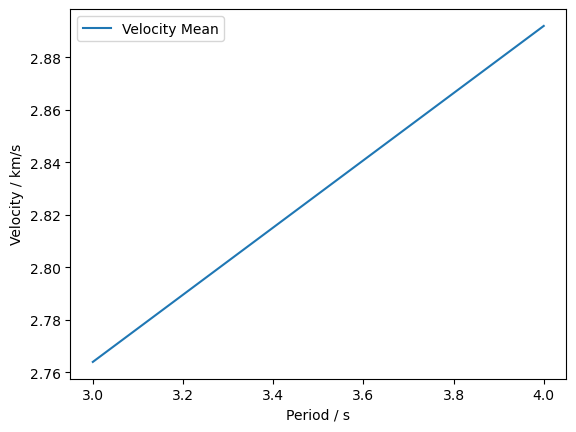

In [8]:
fig, ax= plt.subplots()

ax.plot(backv.keys(), backv.values(), label='Velocity Mean')

print([list(backv.keys()), list(backv.values())])

ax.set_xlabel("Period / s")
ax.set_ylabel("Velocity / km/s")

ax.legend()